In [1]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

from train import conf
import glob
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import utils

In [2]:
animal = 'ST260'
day_name = 'Day1'
exp_pref = f'{animal}_{day_name}'
path_models = f"{conf.path2outputs}/{exp_pref}"

In [3]:
list_files = glob.glob(f"{path_models}/models_*.pkl")

In [21]:
with open(f"{path_models}/models_layer0.pkl","rb") as f:
    results = pkl.load(f)
NN = len(results)+1
WAICs = np.zeros((NN,NN))
WAICs[0,1:] = [a[3] for a in results]
for layer in range(1,len(results)):
    with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
        res = pkl.load(f)
    WAICs[layer,(layer+1):] = [a[3] for a in res]

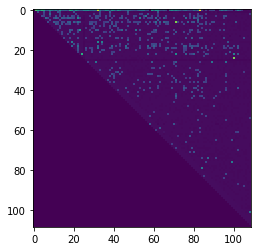

In [5]:
plt.imshow(WAICs[:])

In [89]:
device = "cuda:1"
import tqdm
import bvcopula

# create linspace
N_points = 50
train_x = torch.linspace(0,1,N_points).to(device)

copula_layers = []
for layer in tqdm.tqdm(range(0,NN-1)):
    with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
        results = pkl.load(f)
    out_dir = f'{path_models}/layer{layer}'
    copulas = []
    for n,res in enumerate(results):
        if res[1]!='Independence':
            likelihoods = res[0]
            weights_file = f"{out_dir}/model_{exp_pref}_{layer}-{layer+n+1}.pth"
            model = utils.get_model(weights_file, likelihoods, device)
            with torch.no_grad():
                f = model(train_x).mean
                copula = model.likelihood.get_copula(f)
                copulas.append(copula)
        else:
            copulas.append(bvcopula.MixtureCopula(torch.empty(1,0,device=device),
                    torch.ones(1,N_points,device=device),
                    [bvcopula.IndependenceCopula]))
    copula_layers.append(copulas)

100%|██████████| 108/108 [00:04<00:00, 23.12it/s]


In [16]:
from vine import CVine
vine = CVine(copula_layers[2:],train_x,device=device)

In [14]:
# plt.plot(vine.log_prob(vine.sample()).cpu().numpy())
%time entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=True)

tensor(1.1761, device='cuda:1')
CPU times: user 1min 19s, sys: 23.2 s, total: 1min 42s
Wall time: 1min 35s


In [9]:
samples = vine.sample(torch.Size([100]))

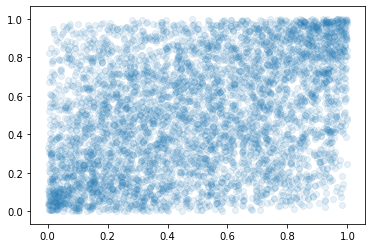

In [10]:
plt.scatter(*samples[...,[0,4]].cpu().numpy().T,alpha=0.1)

In [111]:
indep = bvcopula.MixtureCopula(torch.empty(1,0,device=device),
                    torch.ones(1,N_points,device=device),
                    [bvcopula.IndependenceCopula])
truncated_layers = [[model for model in layer] for layer in copula_layers]
Ncut = (NN-3)-1
for i in range(1,Ncut+1):
    for j in range(i):
        truncated_layers[-i][j] = indep
vine = CVine(truncated_layers,train_x,device=device)

In [112]:
entropy2 = vine.entropy(sem_tol=0.1, mc_size=4000, v=True)

tensor(1.1057, device='cuda:1')


In [27]:
Hrs = []
for n in tqdm.tqdm(range(NN-1)):
    vine = CVine(copula_layers[n:],train_x,device=device)
    entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=True)
    Hrs.append(-entropy.mean().item())

  0%|          | 0/108 [00:00<?, ?it/s]

tensor(1.1754, device='cuda:1')


100%|██████████| 108/108 [06:01<00:00,  3.35s/it]


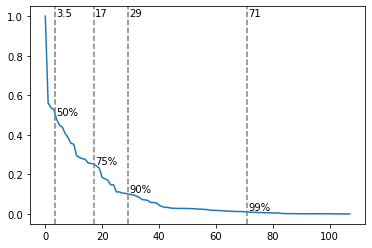

In [108]:
Hrs = np.array(Hrs)
plt.plot(Hrs/Hrs[0])
# plt.axhline(0.01,c='black',linestyle='dashed')
plt.axvline(3.5,c='grey',linestyle='dashed')
plt.axvline(17,c='grey',linestyle='dashed')
plt.axvline(29,c='grey',linestyle='dashed')
plt.axvline(71,c='grey',linestyle='dashed')
plt.text(3.8,1.0,'3.5')
plt.text(17.5,1.0,'17')
plt.text(29.5,1.0,'29')
plt.text(71.5,1.0,'71');
plt.text(3.8,0.5,'50%')
plt.text(17.5,0.25,'75%')
plt.text(29.5,0.11,'90%')
plt.text(71.5,0.02,'99%');

In [116]:
entropy2.mean()/entropy.mean()

tensor(0.5101, device='cuda:1')

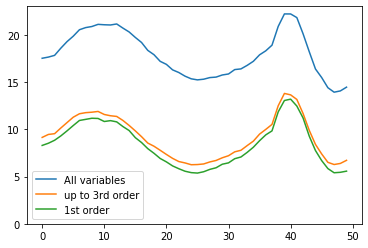

In [117]:
plt.plot(-entropy.cpu().numpy(), label="All variables")
plt.plot(-entropy2.cpu().numpy(), label="up to 3rd order")
plt.plot(-entropy3.cpu().numpy(), label="1st order")
plt.ylim(0,23)
plt.legend();

Text(0, 0.5, 'Entropy')

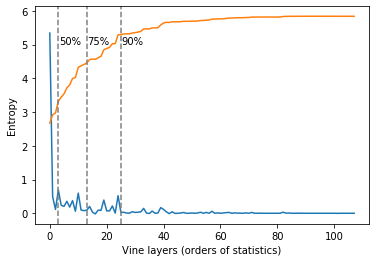

In [17]:
np_repeats = np.array(repeats)
H_layers = np_repeats.mean(axis=0)[::-1]
plt.plot(H_layers)
plt.plot(H_layers.cumsum()/2)
plt.axvline(3,color='grey',linestyle='dashed')
plt.axvline(13,color='grey',linestyle='dashed')
plt.axvline(25,color='grey',linestyle='dashed')
plt.text(3.2,5,'50%')
plt.text(13.2,5,'75%')
plt.text(25.2,5,'90%')
plt.xlabel('Vine layers (orders of statistics)')
plt.ylabel('Entropy')

In [ ]:
H_layers[0].sum()/H_layers.sum()

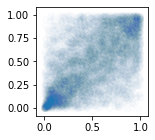

In [65]:
plt.figure(figsize=(2,2))
layer0 = layers[-1]
plt.scatter(layer0[0],layer0[3],alpha=0.01)

In [ ]:
plt.figure(figsize=(2,2))
plt.scatter(samples[...,0].cpu().numpy(),new_samples[...,-1].cpu().numpy(),alpha=0.01)

In [12]:
def generate_samples(samples,NN):
    layers = []
    for layer in torch.arange(NN-1,0):
        # load models for a layer
        with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
            results = pkl.load(f)
        # assign memory for a new layer samples
        new_layer_shape = torch.Size([N_points])+sample_size+torch.Size([NN-1-layer])
        new_samples = torch.empty(size=new_layer_shape, device=device)
        # transfrom samples
        transform(X,layers[-1],new_samples,layer,results)
        # store the result
        layers.append(new_samples.clone())
    return layers
%time samples = generate_samples(samples,NN)

CPU times: user 2min 8s, sys: 529 ms, total: 2min 8s
Wall time: 13.6 s


In [13]:
len(samples)

109